# Outliers

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src import *
datadir = ROOTDIR / 'data' / 'interim'

## Dimension reduction

Apply dimension reduction techniques to the columns ```perimeter_se``` and ```fractal_dimension_se``` from the cancer dataset and study how outliers are mapped.

In [ ]:
raw = pd.read_parquet(datadir / 'breast_cancer.parquet')
print(raw.shape)
raw.head()

(569, 31)


diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  radius_worst  \
id                                            ...                 
842302                0.14710         0.2419  ...         25.38   
842517                0.07017         0.1812  ...         24.99   
84300903              0.12790         0.2069  ...         23.57   
84348301              0.10520         0.2597  ...         14.91   
84358402              0.10430         0.1809  ...         22.54   

          texture_worst  perimeter_worst  area_worst  smoothness_worst  \
id                                                                       
842302            17.33           184.60      2019.0            0.1622   
842517            23.41           158.80      1956.0            0.1238   
84300903          25.53           152.50      1709.0            0.1444   
84348301          26.50            98.87       567.7            0.2098   
84358402          16.67           152.20      1575.0            0.1374   

          compactness_worst  concavity_worst  concave points_worst  \
id                                                                   
842302               0.6656           0.7119                0.2654   
842517               0.1866           0.2416                0.1860   
84300903             0.4245           0.4504                0.2430   
84348301             0.8663           0.6869                0.2575   
84358402             0.2050           0.4000                0.1625   

          symmetry_worst  fractal_dimension_worst  
id                                                 
842302            0.4601                  0.11890  
842517            0.2750                  0.08902  
84300903          0.3613                  0.08758  
84348301          0.6638                  0.17300  
84358402          0.2364                  0.07678  

[5 rows x 31 columns]

In [ ]:
outliers = (raw.perimeter_se>15)|(raw.fractal_dimension_se>0.015)
outliers.mean()

0.01054481546572935

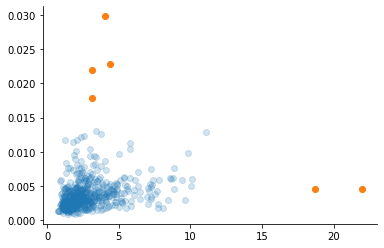

In [ ]:
fig, ax = plt.subplots()
ax.scatter(raw['perimeter_se'], raw['fractal_dimension_se'], alpha=0.2);
ax.scatter(raw.loc[outliers, 'perimeter_se'], raw.loc[outliers, 'fractal_dimension_se']);

We will first consider how outliers behave in the PCA algorithm. 
Those outliers have a tendency to increase the RMS of each variable, hence will likely draw the projection asxis onto them.
Because both dimensions have outliers, the PCA will most likely find a middle ground so that outliers in both dimension can significantly contribute to the variance.
As a result, we get a single dimension in which outliers points are still separated from the remaining points.
It is worth to note however that outliers are less extreme in this smaller space than initially, because PCA had to find linear compromises.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

red = PCA(1)
scaler = StandardScaler()
proj = red.fit_transform(scaler.fit_transform(raw[['perimeter_se', 'fractal_dimension_se']]))

In [ ]:
fig, ax = plt.subplots()
np.random.seed(56)
r = np.random.uniform(size=len(proj))
ax.scatter(r, proj, alpha=0.2)
ax.scatter(r[outliers], proj[outliers]);

The UMAP algorithm works differently and has a very different result.
Because the algorithm normalises the distance between closest neighbours, it turns out that outliers will be compressed so that they have the same density as the main bulk of points.
UMAP has then no incentive to put these points further away.
Moreover, those points are few, so it results that their position suffers more from UMAP compromises that points more integrated in a large cluster.

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler

red = UMAP(n_neighbors=30, n_components=2, random_state=32)
scaler = StandardScaler()
proj = red.fit_transform(scaler.fit_transform(raw[['perimeter_se', 'fractal_dimension_se']]))

/mnt/c/Users/christophe_goudet/Documents/dev/esilv/venv/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
fig, ax = plt.subplots()
ax.scatter(proj[:,0], proj[:,1], alpha=0.2)
ax.scatter(proj[outliers,0], proj[outliers, 1]);

## Interquartile

Apply the interquartile method for outlier detection on the ```perimeter_se``` column of the cancer dataset.
Interpret the results.
Then identify a parametrisation of the distribution and use a parametrised outlier detection.

In this situation, the data does not follow the expect gaussian distribution : most of the data around a central value.
Instead, the distribution looks like an exponential distribution.
Then, the mean, median or interquartile of the distribution do not correspond to any natural parameter of the distribution.
Then the parametrisation as a center and a spread is not suited for this data.

In [ ]:
data = raw['perimeter_se'].copy().values

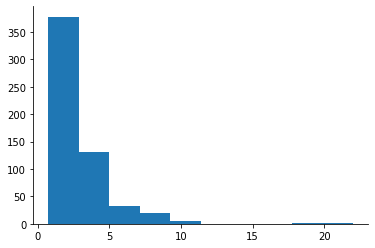

In [ ]:
plt.hist(data);

In [ ]:
from scipy.stats import iqr
d = iqr(data, rng=[25, 75])
d

1.751

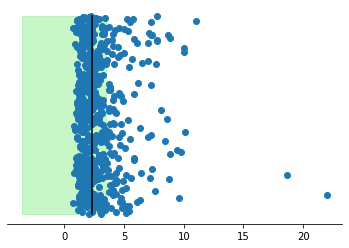

In [ ]:
fig, ax = plt.subplots()
data[-1]=10

ax.fill_between([-2*d, 2*d], [0, 0], [1, 1], color='lightgreen', alpha=0.5)
ax.scatter(data, np.random.uniform(size=len(data)));
ax.plot([np.median(data)]*2, [0, 1], color='black');
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)

We can now try to fit a more suited model : an exponential.
With this modelisation, we can estimate the probability of a point being generated randomly at each value.
Then outliers are points that have a probability to be generated by this exponential below a threshold.

Given this parametrisation of the exponential $e^{ln2 \frac{x}{t}}$, the probabily to generate $x$ is split by half for each step of size $t$.
Then a point at position $10t$ is a thousand times less probable than the point at 0.
Given that we have only 500 points, we dont expect any point above this threshold.

In [ ]:
from scipy.stats import expon
param = expon.fit(data)
param

(0.757, 2.1221558875219686)

In [ ]:
t = param[0]/np.log(2)
threshold = t*10 + data.min()
t, threshold

(1.0921201459529453, 11.678201459529452)

In [ ]:
fig, ax = plt.subplots()
ax.hist(data, bins=50, density=True)
x = np.linspace(param[0], 21, 51)
pdf_fitted = expon.pdf(x, *param)
plt.plot(x,pdf_fitted)
plt.plot([threshold]*2, [0, pdf_fitted.max()], color='red')
plt.show()

## Gaussian mixture

Create the moon dataset and add multiple outliers.
Parametrise the dataset as a combination of multiple gaussians and identify a separation contour between legitimate points and outliers.

In this exercice, we will leverage the property that we can describe most of distributions using a high enough amount of Gaussian.
It the following plot, instead of trying to fit 2 gaussians on the moons dataset, we consider that each moon is made of 8 independent gaussians.
Here, we do not look for clusters, but for a way to cover all meaningfull dataset with a probability distribution.
Then, each point within the moons as a high probability toward at least one Gaussian distribution.
On the contrary, an outlier is expected to lie far from the moons, hence far from any Gaussian.
As a result, any outlier should have a global bad fit with this data driven parametrisation.

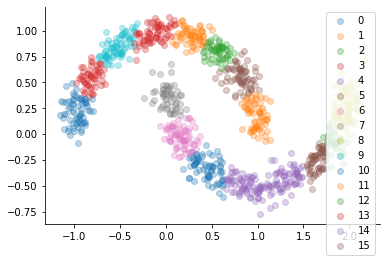

In [ ]:
from sklearn.datasets import make_moons
data, _ = make_moons(1000, noise=0.08)

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=16).fit(data);

from src.visualization.utils import *
labels = gm.predict(data)
plot_clustering(data, labels)

In [ ]:
data[-1] = [-0.5, -0.5]

In the following, we will compute the fit quality for hypothetical points all around the map.
Then when can plot the agreement of each point with the modelisation on a map.
We observe that the only place where the probability is significative is close to the center of gaussians, on the moons.
The rest of the space only has a low probability.

As a result, we can define a threshold which defines a limit from which a point can not be thought as belonging to any of the gaussians.
Then we can identify points which fall below this threshold as outliers.

In [ ]:
# Generate values to test on each axis independently
x = np.linspace(-1.5, 2.5, 50)
y = np.linspace(-0.75, 1.25, 50)

# create all points, combination of x and y
xx, yy = np.meshgrid(x, y)

#get coordinates of all the points in 2D matrix
inp = np.array(list(zip(xx.ravel(), yy.ravel())))

In [ ]:
# compute the score for each point
proba = np.exp(gm.score_samples(inp)).reshape(xx.shape)
proba

array([[8.16392739e-19, 7.98269369e-17, 3.16516636e-15, ...,
        2.77787136e-19, 1.36240820e-22, 2.80947926e-26],
       [6.57297281e-18, 6.64424875e-16, 2.72349559e-14, ...,
        2.53852544e-18, 1.31672275e-21, 2.87161679e-25],
       [4.79320634e-17, 5.00891763e-15, 2.12255230e-13, ...,
        2.11067249e-17, 1.17163544e-20, 2.75509732e-24],
       ...,
       [1.01428976e-22, 4.72930205e-20, 8.94187944e-18, ...,
        2.51422456e-10, 6.04199167e-12, 5.06232757e-14],
       [7.78214554e-24, 3.75118148e-21, 7.33218727e-19, ...,
        6.44181148e-11, 1.67008680e-12, 1.50960783e-14],
       [5.40801942e-25, 2.69488779e-22, 5.44552650e-20, ...,
        1.53042759e-11, 4.28054230e-13, 4.17425391e-15]])

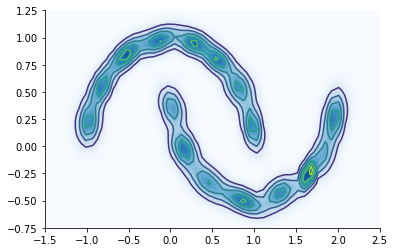

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, proba, shading='gouraud', cmap=plt.cm.Blues)
ax.contour(xx, yy, proba);

threshold 0.006737946999085467


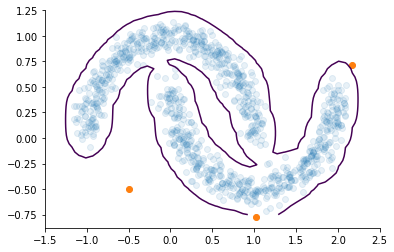

In [ ]:
threshold = np.exp(-5)
print('threshold', threshold)
outliers = np.exp(gm.score_samples(data)) < threshold

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], alpha=0.1)
ax.scatter(data[outliers,0], data[outliers,1])
ax.contour(xx, yy, proba, levels=[threshold]);

### Specific algorithm

Apply all presented algorithms to ```perimeter_se``` and ```fractal_dimension_se``` of the cancer dataset.
Understand how changing the various parameters may impact the results in this simple situation.
Understand how the definition of outlier varies from one algorithm to the next.

#### DBSCAN
In this first part, we will look at how the parameters of DBSCAN impact the results of outlier detection.
Two parameters may have an impact : ```eps``` and ```min_samples```.
A point will be qualified as outlier if it has less than ```min_samples``` neighbours at a distance less than ```eps```.
Increasing ```eps``` will give more chance for a pint to reach enough neighbours, while increasing ```min_samples``` will make it more difficult. 
Let's compare two extreme situtations.

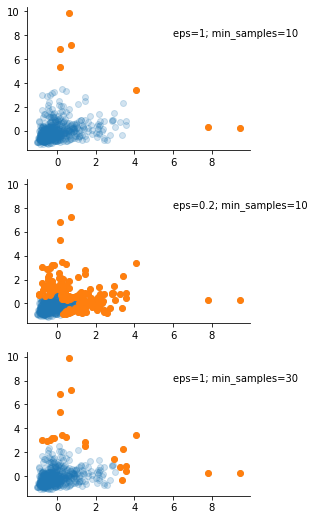

In [ ]:
fig, axs = plt.subplots(3, figsize=(4, 9))
scaled = StandardScaler().fit_transform(raw[['perimeter_se', 'fractal_dimension_se']])

for i in range(3):
    clst = DBSCAN(eps=1 if i!=1 else 0.2, 
                  min_samples=10 if i!=2 else 30)
    labels = clst.fit_predict(scaled)
    outliers = labels ==-1
    axs[i].scatter(*scaled.T, alpha=0.2);
    axs[i].scatter(*scaled[outliers].T);
    axs[i].text(6, 8, f'eps={clst.eps}; min_samples={clst.min_samples}')

Then we can study the case of LocalOutlierFactor.
He we will change only the neighbours parameter.
With more neighbours, the algorithm is able to better assess what the local density is like.
With increasing value, more and more points that do not strctly have the same density will be labelled as outliers.
With ```n_neighbors=3```, we have the interesting fact that the 3 outliers on the y axis are not labelled as such, while the outliers on the x axis are labelled as outliers.
This is specifically because ```n_neighbors=3```.
Indeed the 3 neighbours of the top point on the y axis are also in very sparse area. 
Then, there is no particular discrepancy for the top point to be in sparse area.
Furthermore, the 4th point has its third neighbor in a much denser region (around y=4), which increase the density requirement in order to not be an outlier.

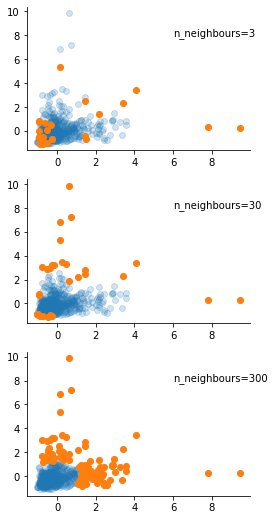

In [ ]:
nrows = 3
fig, axs = plt.subplots(nrows, figsize=(4, 3*nrows))
scaled = StandardScaler().fit_transform(raw[['perimeter_se', 'fractal_dimension_se']])

neigbors = [3, 30, 300]
for i in range(len(axs)):
    clst = LocalOutlierFactor(n_neighbors=neigbors[i])
    labels = clst.fit_predict(scaled)
    outliers = labels ==-1
    axs[i].scatter(*scaled.T, alpha=0.2);
    axs[i].scatter(*scaled[outliers].T);
    axs[i].text(6, 8, f'n_neighbours={clst.n_neighbors}')

We will finish this exercice with the isolation forest.
Here, it is not so much the parameters that is interesting but the way to use the decision function of the algorithm.
We could use isolation forest like the previous algorithms but it seems that the algorithm is a bit too aggressive in the definition of outliers.

Instead, we could directly look at the distribution of the outlier score computed by the forest.
We could then define a threshold for outliers.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=1000, max_samples = 0.7, max_features=2,
                      bootstrap=True, n_jobs=-1, random_state=0)
labels = clf.fit_predict(scaled)
outliers = labels == -1

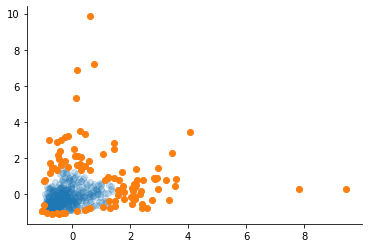

In [ ]:
fig, ax = plt.subplots()
ax.scatter(*scaled.T, alpha=0.2);
ax.scatter(*scaled[outliers].T);

In [ ]:
probas = clf.decision_function(scaled)
plt.hist(probas, bins=50);

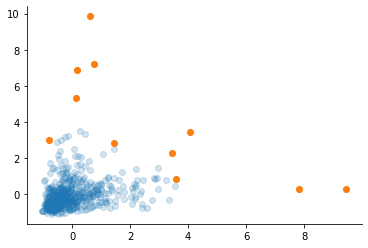

In [ ]:
outliers = probas < -0.15
fig, ax = plt.subplots()
ax.scatter(*scaled.T, alpha=0.2);
ax.scatter(*scaled[outliers].T);